In [12]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *
from tqdm import tqdm

In [13]:
country_returns = pd.read_pickle('../Outputs/equity/equity_etf_returns_weekly.pkl')

equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')
equity_factors = equity_factors[equity_factors.momentum.notnull()]

clusters = pd.read_pickle('../Outputs/country_clusters/clusters_equity_etf_full.pkl')
clusters = clusters.groupby('cluster_label')['Countries'].apply(list).to_dict()
equity_clusters = []
for k in clusters.keys():
    ew_returns = country_returns[clusters[k]].mean(axis=1)
    equity_clusters.append(ew_returns)
equity_clusters = pd.concat(equity_clusters,axis=1)
equity_clusters = equity_clusters.loc[equity_factors.index]

In [23]:
# x is a Pandas object here

def mu_(x):
    return x.mean()
def cov_(x):
    return x.cov()
def obj_(w, x, gamma = 1):
    u = mu_(x)
    V = cov_(x)
    return w @ V @ w.T - gamma * w.T @ u


def opt(rtn):    
    noa = len(rtn.columns)
    guess = noa * [1. / noa,] # equal-weight for initial guess

    cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.},
           {'type': 'ineq', 'fun': lambda x: abs(x[0]) - 1.},
           {'type': 'ineq', 'fun': lambda x: abs(x[1]) - 1.},
           {'type': 'ineq', 'fun': lambda x: abs(x[2]) - 1.}] 
    if noa==4:
        cons.append({'type': 'ineq', 'fun': lambda x: abs(x[3]) - 1.})
    #{'type': 'ineq', 'fun': lambda x: 1.5-x[0]},
#            {'type': 'ineq', 'fun': lambda x: 1.5-x[1]},
#            {'type': 'ineq', 'fun': lambda x: 1.5-x[2]},
#            {'type': 'ineq', 'fun': lambda x: 1.5-x[3]}
    opt = minimize(obj_, guess, args=(rtn,), method='SLSQP', 
                   constraints=cons, tol=1e-10)
    return opt.x

def opt_multi(rtn, window = 52):
    dates = rtn.index
    w_ = []
    for d in tqdm(range(len(dates)-window)):
        date_idx = dates[d:d+window+1]
        try:
            rtn_t = rtn.loc[date_idx]
            res = opt(rtn_t)
            w_.append(res)
        except:
            continue
    w_ = np.matrix(w_)
    final_w = pd.DataFrame(w_,columns = rtn.columns, index = dates[-w_.shape[0]:])
    return final_w

# 1a. Country MVP

In [24]:
cntry_w = opt_multi(country_returns.loc['2016/9/1':])
# cntry_w1 = cntry_w.divide(cntry_w.abs().sum(axis=1),axis=0)

100%|██████████| 179/179 [08:47<00:00,  2.95s/it]


In [102]:
# eq weighted
cntry_w2 = pd.DataFrame(np.ones(cntry_w.shape)*(1/23), index=country_returns.iloc[-len(cntry_w):].index, columns=country_returns.columns)

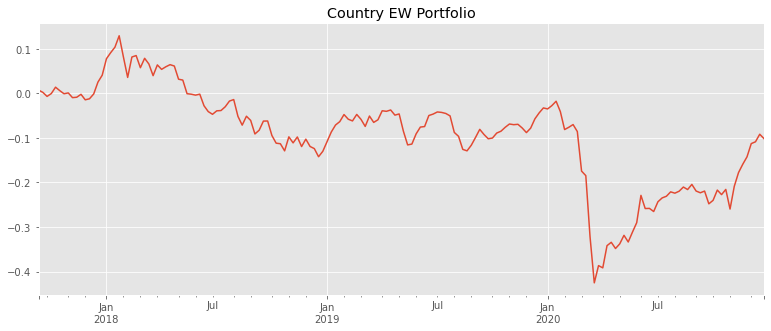

In [103]:
cntry_rtn = np.sum(cntry_w2.loc['2017/9/17':'2020/12/31'] * country_returns.loc['2017/9/17':'2020/12/31'], axis=1)
((cntry_rtn+1).cumprod()-1).plot(figsize = (13,5),title = 'Country EW Portfolio');

# 1b. Cluster MVP

In [104]:
cluster_w = opt_multi(equity_clusters)

100%|██████████| 176/176 [00:21<00:00,  8.00it/s]


In [143]:
cluster_w1 = pd.DataFrame(cluster_w, index=equity_clusters.iloc[-len(cluster_w):].index, columns=equity_clusters.columns)

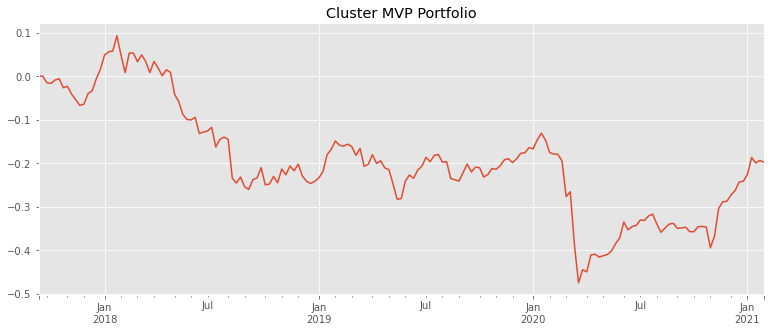

In [144]:
cluster_rtn = np.sum(cluster_w1.loc['2017/9/17':] * equity_clusters.loc['2017/9/17':], axis=1)
((cluster_rtn+1).cumprod()-1).plot(figsize = (13,5),title = 'Cluster MVP Portfolio');

# 1c. Factor MVP

In [108]:
factors4 = ['size', 'value', 'momentum', 'low_beta']
factor4_w = opt_multi(equity_factors[factors4])

100%|██████████| 176/176 [00:23<00:00,  7.42it/s]


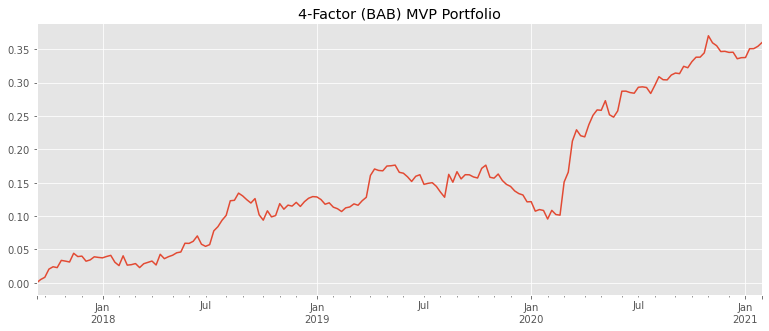

In [109]:
factor4_rtn = np.sum(factor4_w.loc['2017/9/17':] * equity_factors[factors4].loc['2017/9/17':], axis=1)
((factor4_rtn+1).cumprod()-1).plot(figsize = (13,5),title = '4-Factor (BAB) MVP Portfolio');

In [110]:
factors4_mkt = ['size', 'value', 'momentum', 'market-rf']
factor4_mkt_w = opt_multi(equity_factors[factors4_mkt])

100%|██████████| 176/176 [00:25<00:00,  6.88it/s]


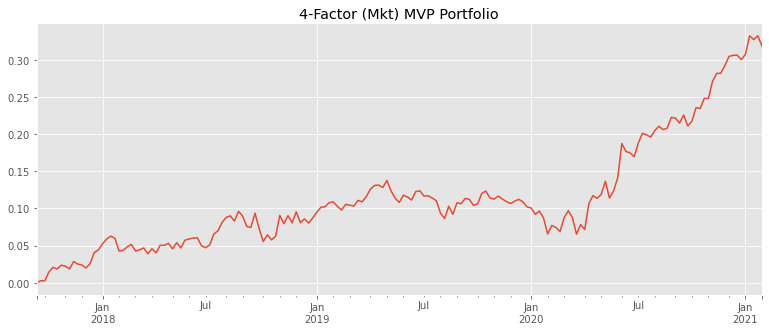

In [111]:
factor4_mkt_rtn = np.sum(factor4_mkt_w.loc['2017/9/17':] * equity_factors[factors4_mkt].loc['2017/9/17':], axis=1)
((factor4_mkt_rtn+1).cumprod()-1).plot(figsize = (13,5),title = '4-Factor (Mkt) MVP Portfolio');

In [112]:
factors_3= ['size', 'value', 'momentum']
factor3_w = opt_multi(equity_factors[factors_3])

100%|██████████| 176/176 [00:25<00:00,  6.84it/s]


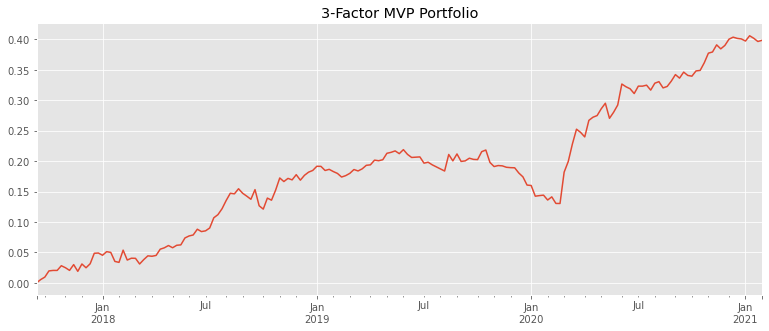

In [113]:
factor3_rtn = np.sum(factor3_w.loc['2017/9/17':] * equity_factors[factors_3].loc['2017/9/17':], axis=1)
((factor3_rtn+1).cumprod()-1).plot(figsize = (13,5),title = '3-Factor MVP Portfolio');

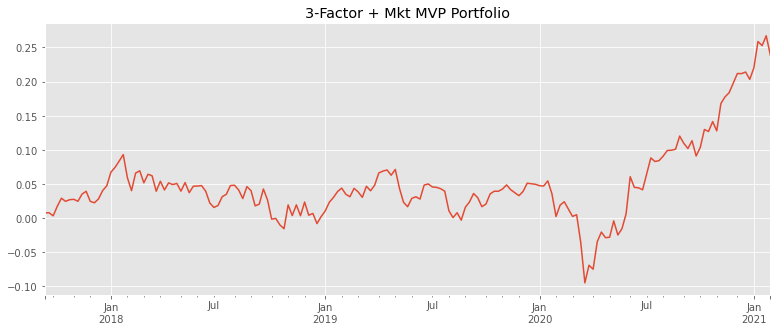

In [114]:
f3_mkt = pd.concat([factor3_rtn,equity_factors['market-rf']],axis=1).dropna()
f3_mkt['Combined'] = (f3_mkt[0] + f3_mkt['market-rf'])/2
((f3_mkt['Combined']+1).cumprod()-1).plot(figsize = (13,5),title = '3-Factor + Mkt MVP Portfolio');

# 1d. DM Extension

In [115]:
dm_equity_factors = pd.read_pickle('../Outputs/equity/equity_DM_country_factors.pkl')

In [116]:
factors_4= ['size', 'value', 'momentum', 'low_beta']

dm_factor4_w = opt_multi(dm_equity_factors[factors_4])

100%|██████████| 228/228 [00:29<00:00,  7.86it/s]


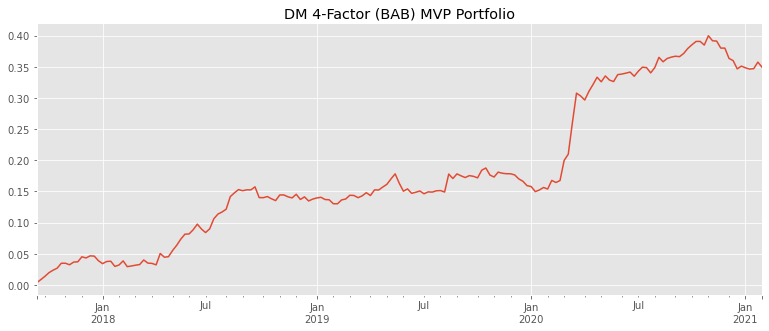

In [117]:
dm_factor4_rtn = np.sum(dm_factor4_w.loc['2017/9/17':] * dm_equity_factors[factors_4].loc['2017/9/17':], 
                        axis=1)
((dm_factor4_rtn+1).cumprod()-1).plot(figsize = (13,5),title = 'DM 4-Factor (BAB) MVP Portfolio');

In [118]:
factors_3= ['size', 'value', 'momentum']

dm_factor3_w = opt_multi(dm_equity_factors[factors_3])

100%|██████████| 228/228 [00:33<00:00,  6.88it/s]


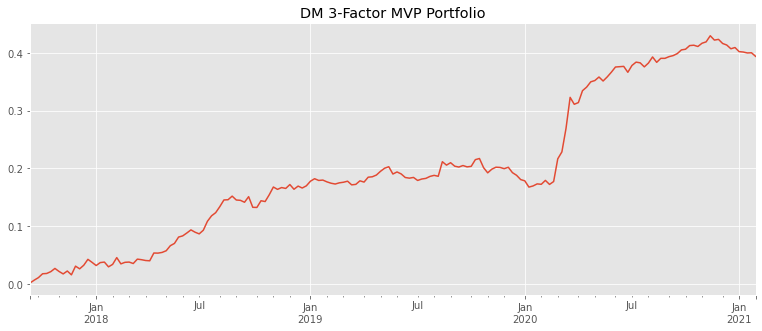

In [119]:
dm_factor3_rtn = np.sum(dm_factor3_w.loc['2017/9/17':] * dm_equity_factors[factors_3].loc['2017/9/17':], 
                        axis=1)
((dm_factor3_rtn+1).cumprod()-1).plot(figsize = (13,5),title = 'DM 3-Factor MVP Portfolio');

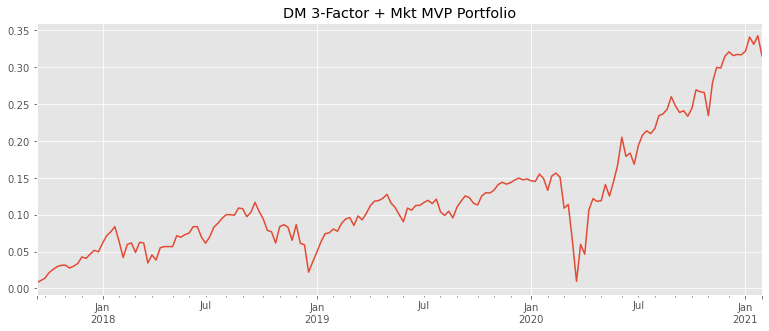

In [120]:
dm_f3_mkt = pd.concat([dm_factor3_rtn,dm_equity_factors['Mkt-RF']],axis=1).dropna()
dm_f3_mkt['Combined'] = (dm_f3_mkt[0] + dm_f3_mkt['Mkt-RF'])/2
((dm_f3_mkt['Combined']+1).cumprod()-1).plot(figsize = (13,5),title = 'DM 3-Factor + Mkt MVP Portfolio');

# Comparison

In [146]:
portfolios = [cntry_rtn, cluster_rtn, 
              factor4_rtn,factor4_mkt_rtn,
              factor3_rtn,f3_mkt['Combined'],
              dm_factor4_rtn, dm_f3_mkt['Combined'],dm_factor3_rtn,equity_factors['market-rf']]
all_mvp_raw = pd.concat(portfolios,axis=1)
all_mvp = all_mvp_raw.dropna()
all_mvp.columns = ['Country EW', 'Cluster',
                 '4-Factor (BAB)','4-Factor (Mkt)',
                  '3-Factor','3-Factor+Mkt',
                 'DM 4-Factor (BAB)','DM 3-Factor+Mkt','DM 3-Factor','Market']

perf_df = {}
for c in all_mvp:
    res = calc_performance(all_mvp[c], log_ret = False, time = 52, mkt=equity_factors['market-rf'])
    perf_df[c] = res

dfidx = ['Ann Return','Ann Std','Ann SR',
         'Skewness','Kurtosis','Max Drawdown','Max DD Date', 'Market Beta', 'Market Correlation']
perf_df = pd.DataFrame(perf_df, index = dfidx)
perf_df

,Country EW,Country MVP,Cluster,4-Factor (BAB),4-Factor (Mkt),3-Factor,3-Factor+Mkt,DM 4-Factor (BAB),DM 3-Factor+Mkt,DM 3-Factor,Market
Ann Return,-3.19,3.32,-8.03,9.19,8.26,10.72,5.75,9.52,8.68,10.92,-0.3
Ann Std,20.94,30.14,22.68,6.6,6.59,6.2,10.57,5.37,9.55,5.24,20.94
Ann SR,-0.15,0.11,-0.35,1.39,1.25,1.73,0.54,1.77,0.91,2.09,-0.01
Skewness,-2.28,-0.68,-1.86,1.29,0.47,0.82,-0.31,1.79,-0.27,1.77,-1.07
Kurtosis,13.3,8.76,8.55,4.16,1.8,3.66,2.57,7.4,4.46,7.81,4.66
Max Drawdown,49.11,50.0,51.98,6.87,6.35,7.25,17.18,3.8,12.7,4.06,45.18
Max DD Date,2020-03-22,2020-03-22,2020-03-22,2020-02-02,2020-03-22,2020-02-23,2020-03-22,2020-12-20,2020-03-22,2020-01-12,2020-03-22
Market Beta,0.933,1.051,0.82,-0.019,0.218,-0.036,0.476,-0.088,0.38,-0.086,1.0
Market Correlation,0.917,0.735,0.746,-0.063,0.705,-0.125,0.955,-0.352,0.845,-0.352,1.0


In [159]:
pd.read_html(html,index_col=0)[0].iloc[:,3:].T

,Ann Return,Ann Std,Ann SR,Skewness,Kurtosis,Max Drawdown,Max DD Date,Market Beta,Market Correlation
4-Factor (BAB),9.19,6.6,1.39,1.29,4.16,6.87,2020-02-02,-0.019,-0.063
4-Factor (Mkt),8.26,6.59,1.25,0.47,1.8,6.35,2020-03-22,0.218,0.705
3-Factor,10.72,6.2,1.73,0.82,3.66,7.25,2020-02-23,-0.036,-0.125
3-Factor+Mkt,5.75,10.57,0.54,-0.31,2.57,17.18,2020-03-22,0.476,0.955
DM 4-Factor (BAB),9.52,5.37,1.77,1.79,7.4,3.8,2020-12-20,-0.088,-0.352
DM 3-Factor+Mkt,8.68,9.55,0.91,-0.27,4.46,12.7,2020-03-22,0.38,0.845
DM 3-Factor,10.92,5.24,2.09,1.77,7.81,4.06,2020-01-12,-0.086,-0.352
Market,-0.3,20.94,-0.01,-1.07,4.66,45.18,2020-03-22,1.0,1.0


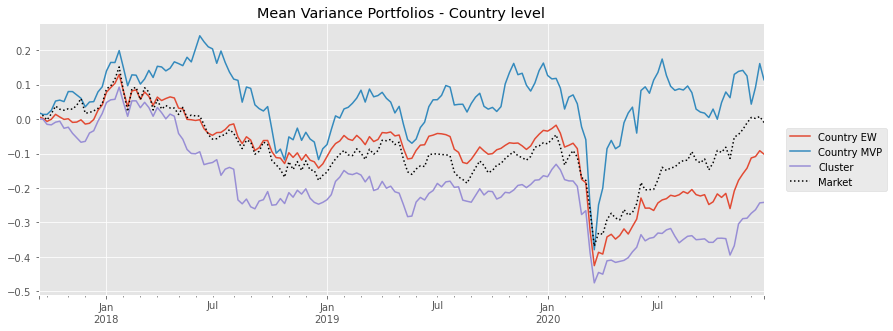

In [162]:
((1+all_mvp.iloc[:,:3]).cumprod()-1).plot(figsize=(13,5), title = 'Mean Variance Portfolios - Country level')
((1+all_mvp.iloc[:,-1]).cumprod()-1).plot(color = 'k',style = ':',legend = True)
plt.legend(bbox_to_anchor=[1.1, 0.5], loc='center');

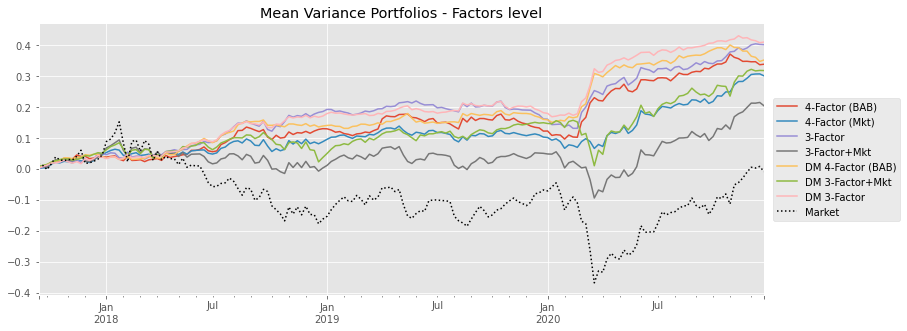

In [147]:
((1+all_mvp.iloc[:,:-1]).cumprod()-1).plot(figsize=(13,5), title = 'Mean Variance Portfolios - Factors level')
((1+all_mvp.iloc[:,-1]).cumprod()-1).plot(color = 'k',style = ':',legend = True)
plt.legend(bbox_to_anchor=[1.1, 0.5], loc='center');

In [149]:
perf_df[[perf_df.columns[i] for i in range(3, len(perf_df.columns))]]

,4-Factor (BAB),4-Factor (Mkt),3-Factor,3-Factor+Mkt,DM 4-Factor (BAB),DM 3-Factor+Mkt,DM 3-Factor,Market
Ann Return,9.19,8.26,10.72,5.75,9.52,8.68,10.92,-0.3
Ann Std,6.6,6.59,6.2,10.57,5.37,9.55,5.24,20.94
Ann SR,1.39,1.25,1.73,0.54,1.77,0.91,2.09,-0.01
Skewness,1.29,0.47,0.82,-0.31,1.79,-0.27,1.77,-1.07
Kurtosis,4.16,1.8,3.66,2.57,7.4,4.46,7.81,4.66
Max Drawdown,6.87,6.35,7.25,17.18,3.8,12.7,4.06,45.18
Max DD Date,2020-02-02,2020-03-22,2020-02-23,2020-03-22,2020-12-20,2020-03-22,2020-01-12,2020-03-22
Market Beta,-0.019,0.218,-0.036,0.476,-0.088,0.38,-0.086,1.0
Market Correlation,-0.063,0.705,-0.125,0.955,-0.352,0.845,-0.352,1.0


In [25]:
all_mvp.to_pickle('all_mvp.pickle')

# Archive

In [105]:
# cvxpy portfolio optimization.

import cvxpy as cp

def cvx_multi(rtn, window = 52):
    dates = rtn.index
    w_,d_ = [],[]
    for d in tqdm(range(len(dates)-window)):
        date_idx = dates[d:d+window]
        try:
            rtn_t = rtn.loc[date_idx]
            n = 23
            mu = country_returns.mean().values
            Sigma = country_returns.cov().values
            w = cp.Variable(n)
            gamma = cp.Parameter(nonneg=True)
            gamma.value = 1
            ret = mu.T*w 
            risk = cp.quad_form(w, Sigma)
            prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                           [cp.sum(w) == 1, 
                            w >= -.5, w<=1.5])
            prob.solve()
            w_.append(ret.value)
            d_.append(dates[d+window])
        except:
            continue
    w_ = np.matrix(w_)
#     final_w = pd.DataFrame(w_,columns = rtn.columns, index = dates[-w_.shape[0]:])
    return w_,d_

In [106]:
cvx_cntry_rtn, cvx_dates = cvx_multi(country_returns.loc['2016/9/1':])

  0%|          | 0/179 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/opt/conda/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/opt/conda/lib/python3.7/site-package

In [117]:
cvx_cntry_rtn = pd.DataFrame(np.array(cvx_cntry_rtn).squeeze(),index = cvx_dates)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


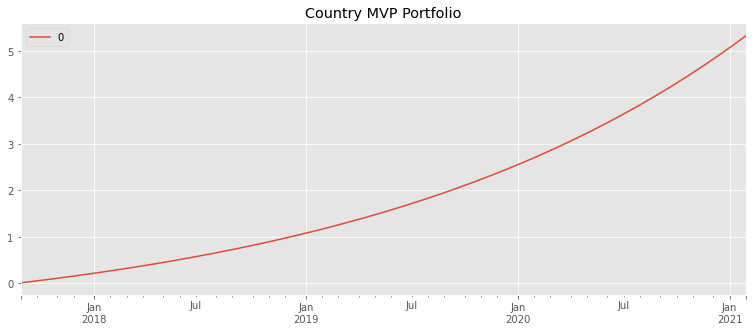

In [118]:
((cvx_cntry_rtn+1).cumprod()-1).plot(figsize = (13,5),title = 'Country MVP Portfolio');